In [6]:
import warnings
import pandas as pd  
import numpy as np   


import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  


import tensorflow as tf   
import keras    
from keras import models 
from keras import layers 
from keras import optimizers
import random
random.seed(2505)  

warnings.filterwarnings('ignore', category=FutureWarning, module='yfinance|pandas')

In [7]:
# Reading in Apple historical stock data
df = pd.read_csv('AAPL_data.csv')    

df.drop(columns='Name',inplace=True) 


# converting dates to datetime 
df['date'] = pd.to_datetime(df['date']) 

df.set_index('date', inplace= True)      


print(df.shape)  

df.head()


(1259, 5)


,open,high,low,close,volume
date,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154


In [9]:
df['mv_avg_short'] = df['close'].rolling(window=5).mean() 
df['mv_avg_long'] = df['close'].rolling(window=50).mean()

In [10]:

scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = pd.DataFrame(scaler.fit_transform(df[["high","low","open","close","volume",
                                                 "mv_avg_short","mv_avg_long"]].values)) 
 
df_scaled = df_scaled.iloc[50:,:] 

df_scaled.head()

,0,1,2,3,4,5,6
50,0.010197,0.015893,0.018465,0.018050,0.584611,0.000000,0.011221
51,0.018174,0.008579,0.006420,0.017277,0.904267,0.000627,0.009320
52,0.016653,0.025387,0.026804,0.020653,0.330944,0.004473,0.007801
53,0.022261,0.026836,0.025172,0.030864,0.703054,0.010756,0.006529
54,0.039504,0.040457,0.037436,0.045807,0.581471,0.018163,0.005598


In [11]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 60 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(df_scaled.shape[0] - samples): 
    X.append(df_scaled.iloc[i:i+samples,[0,1,2,4,5,6]].values) # Independent Samples
    Y.append(df_scaled.iloc[i+samples, [3]].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  60 :  [array([[1.01971885e-02, 1.58931090e-02, 1.84645224e-02, 5.84610720e-01,
        0.00000000e+00, 1.12213990e-02],
       [1.81743098e-02, 8.57867600e-03, 6.41974153e-03, 9.04267406e-01,
        6.26989844e-04, 9.32025238e-03],
       [1.66525355e-02, 2.53871034e-02, 2.68036513e-02, 3.30943565e-01,
        4.47301116e-03, 7.80071827e-03],
       [2.22608266e-02, 2.68363576e-02, 2.51722931e-02, 7.03053555e-01,
        1.07557692e-02, 6.52923052e-03],
       [3.95035374e-02, 4.04565881e-02, 3.74357179e-02, 5.81470533e-01,
        1.81630863e-02, 5.59818103e-03],
       [5.30133489e-02, 5.44484638e-02, 5.43213243e-02, 6.31512987e-01,
        2.67950366e-02, 5.15446756e-03],
       [5.26418473e-02, 5.71384289e-02, 6.51091041e-02, 4.51305496e-01,
        3.47624074e-02, 4.62601088e-03],
       [5.68917597e-02, 6.43717167e-02, 6.20206574e-02, 3.68006021e-01,
        4.35099297e-02, 4.54099961e-03],
       [6.22805641e-02, 7.42479052e-02, 7.30044907e-02, 3.08756

In [12]:
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1149, 60, 6) Dimensions of Y (1149, 1)


In [14]:
# # Get the training and testing set
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:] 
print(threshold)
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

1034
Training Length (1034, 60, 6) (1034, 1) Testing Length: (115, 60, 6) (115, 1)


In [15]:
# Stack the Layers Lineary for time-series data
model = models.Sequential() 
    # First GRU layer with Dropout regularisation
model.add(layers.GRU(units=50, return_sequences=True, input_shape=(X.shape[1],X.shape[2]), activation='tanh'))
model.add(layers.Dropout(0.2))  

    # units: the number of neruons/epochs that run in parralell   
    # return_sequence: if true, allows the sequence of outputs to be passed to the next layer, which maintains the time dimension across layers (bc stock in time-series) 
    # activation: introduces non-linear properties to the model 'tanh' used for hidden layers of network, 'sigmoid' used for binary classification 
    # dropout: regularization technique to prevent over fitting, randomly dropping 20% of the units connections during training, helps model generalize

    # Second GRU layer
model.add(layers.GRU(units=50, return_sequences=True, input_shape= (X.shape[1],X.shape[2]), activation='tanh'))
model.add(layers.Dropout(0.2))
    
    # Third GRU layer
model.add(layers.GRU(units=50, return_sequences=True, input_shape = (X.shape[1],X.shape[2]), activation='tanh'))
model.add(layers.Dropout(0.2)) 

    # Fourth GRU layer
model.add(layers.GRU(units=50, activation='tanh'))
model.add(layers.Dropout(0.2)) 

    # The output layer
model.add(layers.Dense(units=1))   
    # return squence is false because this is our final layer 


model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            8700      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

In [16]:
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
26/26 [==============================] - 3s 49ms/step - loss: 0.0133 - val_loss: 0.1722
Epoch 2/100
26/26 [==============================] - 1s 29ms/step - loss: 0.0298 - val_loss: 0.1717
Epoch 3/100
26/26 [==============================] - 1s 29ms/step - loss: 0.0423 - val_loss: 0.0747
Epoch 4/100
26/26 [==============================] - 1s 30ms/step - loss: 0.0643 - val_loss: 0.0171
Epoch 5/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0663 - val_loss: 0.0136
Epoch 6/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0527 - val_loss: 0.0122
Epoch 7/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0342 - val_loss: 0.0070
Epoch 8/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0191 - val_loss: 0.0034
Epoch 9/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 10/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0040 - val_loss: 0.0057

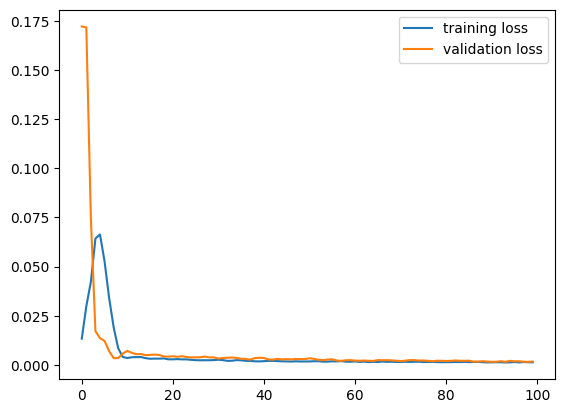

In [17]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()

4/4 [==============================] - 0s 7ms/step


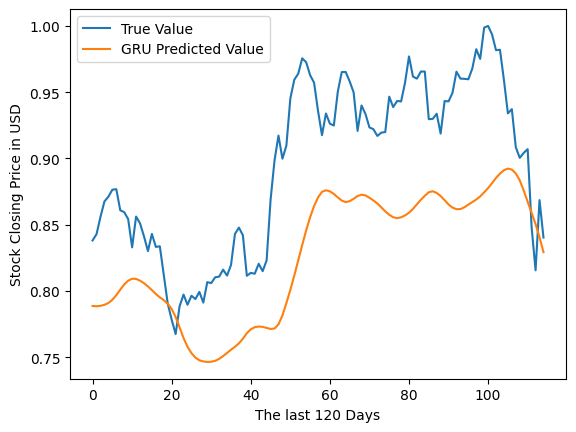

In [18]:
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')   
plt.plot(y_pred[:,0],label='GRU Predicted Value')  
plt.xlabel("The last 120 Days") 
plt.ylabel("Stock Closing Price in USD")
plt.legend()

In [20]:

# Compute evaluation metrics
output_index = 0  # Index of the output column to evaluate
mse = mean_squared_error(testY, y_pred[:, output_index])
mae = mean_absolute_error(testY, y_pred[:, output_index])
r2 = r2_score(testY, y_pred[:, output_index])

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 0.005820954610971498
Mean Absolute Error (MAE): 0.06854299718006253
R-squared Score (R2): -0.4158796845534336
